<a href="https://colab.research.google.com/github/ceyxasm/ml/blob/main/cali_housing_ltd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np


In [2]:
data=pd.read_csv('/content/housing.csv')
print(data.head())
print(data.info())

#dataset at: https://www.kaggle.com/camnugent/california-housing-prices

   longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-nu

In [3]:
data['ocean_proximity'].value_counts() #as ocean had object values; to look into categories

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [4]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


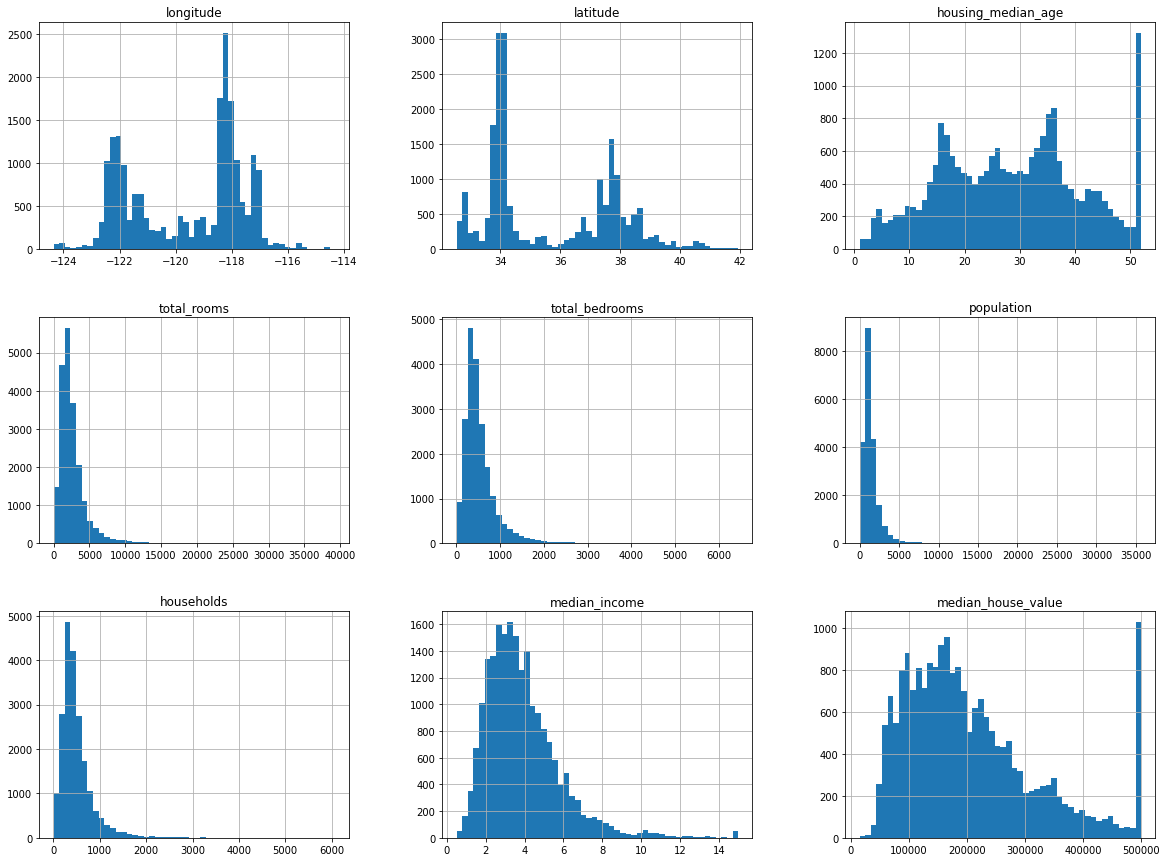

In [5]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [6]:
##CLEARLY houing_median_age and median_house_value are capped: Solution: DROP  THEM BINS
## Machine Learning algorithms may learn that prices never go beyond that limit.
## feature scaling required
## tail heaviness, head-heaviness should be removed

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

It may sound strange to voluntarily set aside part of the data at this stage. After all,
you have only taken a quick glance at the data, and surely you should learn a whole
lot more about it before you decide what algorithms to use, right? This is true, but
your brain is an amazing pattern detection system, which means that it is highly
prone to overfitting: if you look at the test set, you may stumble upon some seemingly
interesting pattern in the test data that leads you to select a particular kind of
Machine Learning model. When you estimate the generalization error using the test
set, your estimate will be too optimistic and you will launch a system that will not
perform as well as expected. This is called data snooping bias.

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64


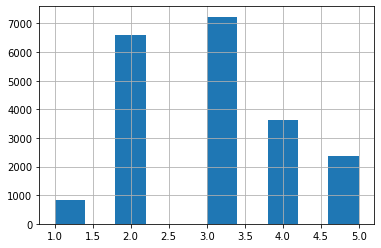

In [7]:
##our median income distribution is skewed and since it is a significant label, we should ensure stratified sampling on median_income
##therefore
data["income_cat"] = pd.cut(data["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
data['income_cat'].hist()


print(data["income_cat"].value_counts() / len(data))


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(data, data["income_cat"]):
  strat_train_set = data.loc[train_index]
  strat_test_set = data.loc[test_index]


print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

#having done stratified sampling; we now drop the income_cat attribute
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

##This procedure reduces sampling bais

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64


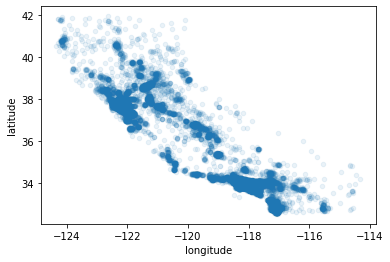

In [9]:
##Next is data visualization
view=strat_train_set.copy()
view.plot(kind='scatter', x='longitude', y='latitude', alpha=0.09)

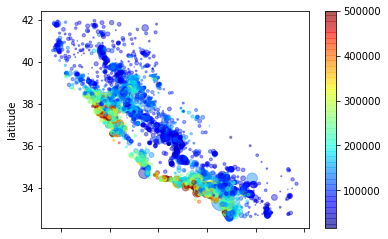

In [10]:
view.plot( kind='scatter', x='longitude', y='latitude', s=view['population']/100, alpha=0.4, c=view['median_house_value'], cmap=plt.get_cmap('jet'), colorbar=True)

In [11]:
## standard correlation coefficient ( Pearson’s r)

##Next we look up for co-relations
## ONLY LINEAR CORELATIONS TAKEN INTO REGARDS
corr_matrix=view.corr()
print( corr_matrix['median_house_value'].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2a98f4cd0>,
      dtype=object)

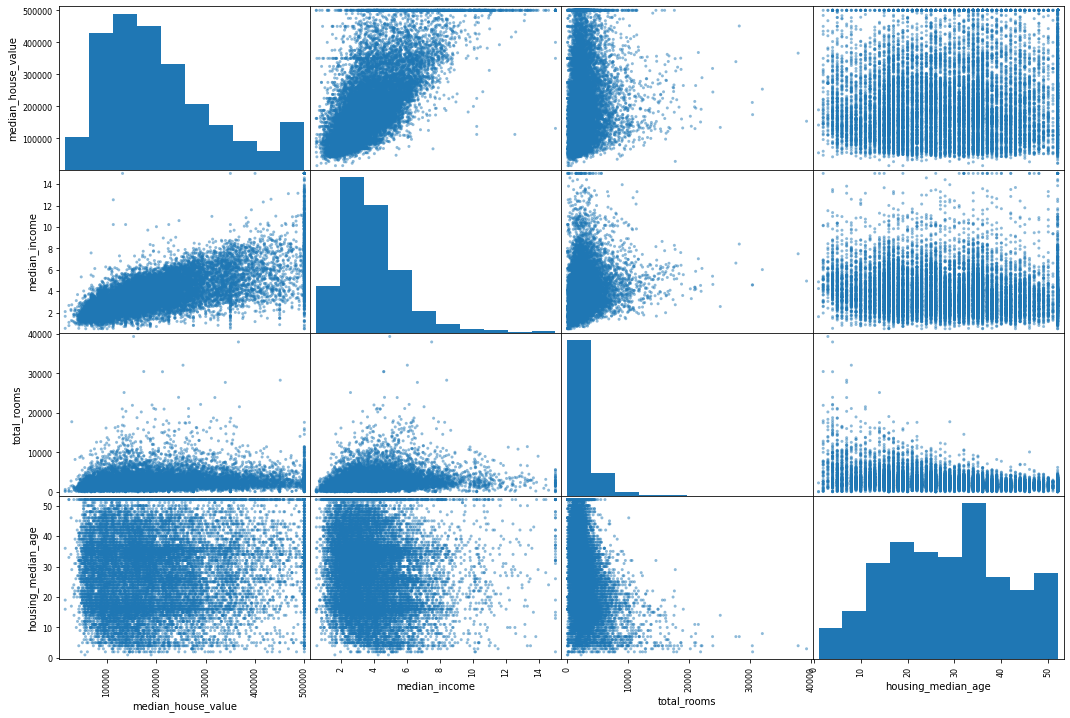

In [12]:
#for better comparisons, lets plot a scatter matrix
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(view[attributes], figsize=(18, 12))

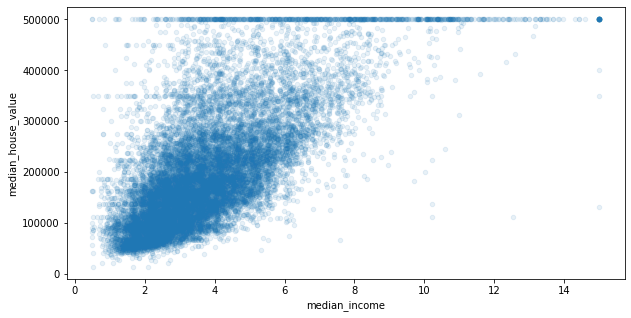

In [13]:
##most significant attribute appears to be median_income, therefore we investigate it a little more
view.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1, figsize=(10,5))

In [14]:
##the price
#cap that we noticed earlier is clearly visible as a horizontal line at $500,000. But this
#plot reveals other less obvious straight lines: a horizontal line around $450,000,
#another around $350,000, perhaps one around $280,000, and a few more below that.
#You may want to try removing the corresponding districts to prevent your algorithms
#from learning to reproduce these data quirks.

In [15]:
## ATTRIBUTE COMBINATION
#some of our attributes can be transformed as rooms_per_household, bedrooms_per_household and population_per_household

data['rooms_per_household']= data['total_rooms']/data['households']
data['bedrooms_per_room'] =data['total_bedrooms']/data['total_rooms']
data['population_per_household']= data['population']/data['households']

In [16]:
corr_matrix= data.corr()
corr_matrix['median_house_value'].sort_values(ascending= False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [17]:
## clearly bedrooms_per_room is a better attribute than no. of bedrooms and no. of rooms both

 **DATA PREPERATION AND CLEANING**

In [18]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

You noticed earlier that the total_bedrooms
attribute has some missing values, so let’s fix this. You have three options:
• Get rid of the corresponding districts.
• Get rid of the whole attribute.
• Set the values to some value (zero, the mean, the median, etc.).
You can accomplish these easily using DataFrame’s dropna() , drop() , and fillna()
methods:


housing.dropna(subset=["total_bedrooms"])
\# option 1

housing.drop("total_bedrooms", axis=1)     \# option 2

median = housing["total_bedrooms"].median() 

housing["total_bedrooms"].fillna(median, inplace=True)
\# option 3

In [19]:
## To implement 3rd option, we have an Inbuilt tool
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

##Since median has meaning only in numerical attributes, we need to create a copy of our data without ocean_proximity attribute

housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num) ##fills missing values but returns a 2D numpy array
housing_tr = pd.DataFrame(X, columns=housing_num.columns) ## to convert back to pandas dataframe

In [22]:
##going back; we left ocean proximity as mean doesnt make sense
## since ML algos work best with numbers( not necessarily categories); we will do the following
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

housing_cat = housing[["ocean_proximity"]]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [23]:
## issue with the above categorical encoding; 0 and 4 are more similar than 0 and 1
## Solution: one-hot encoding
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

If a categorical attribute has a large number of possible categories
(e.g., country code, profession, species, etc.), then one-hot encod‐
ing will result in a large number of input features. This may slow
down training and degrade performance. If this happens, you may
want to replace the categorical input with useful numerical features
related to the categories: for example, you could replace the
ocean_proximity feature with the distance to the ocean (similarly,
a country code could be replaced with the country’s population and
GDP per capita). Alternatively, you could replace each category
with a learnable low dimensional vector called an embedding.

**Feature Scaling**

Minmax Scaling

Standardization

As with all the transformations, it is important to fit the scalers to
the training data only, not to the full dataset (including the test set).
Only then can you use them to transform the training set and the
test set (and new data). 

In [26]:
## TRANSFORMATION PIPELINES <<<<<<<<<<<<<<<<<<<<<to be revisited
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('std_scaler', StandardScaler())
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [27]:
## COLUMN TRANSFORMATION PIPELINE <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<to be revisited
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
                   ("num", num_pipeline, num_attribs),
                   ("cat", OneHotEncoder(), cat_attribs),
                    ])
housing_prepared = full_pipeline.fit_transform(housing)

In [28]:
## Implementing a Simple Linear Regression model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [30]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69050.56219504567

In [31]:
## this is bad so we try to implement some complex models
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [ ]:
## and this has to be unreal; 
##clearly our model has overfit but how can we be sure
##we cannot touch our test data unless we are sure to deploy our model

##so we can have further splits of training data as training and validation sets

**Scikit-Learn’s K-fold cross-validation feature**

The following code randomly splits the training set into 10 distinct subsets called folds, then it
trains and evaluates the Decision Tree model 10 times, picking a different fold for
evaluation every time and training on the other 9 folds. The result is an array con‐
taining the 10 evaluation scores:

In [32]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                          scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [33]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [69670.78310483 68946.65844739 65087.09404563 69234.97073489
 67638.22823129 68789.3340235  72863.03235768 69365.50974635
 67087.22856752 71505.72645411]
Mean: 69018.85657132047
Standard deviation: 2066.5929046809356


In [34]:
## this is even worse than Linear Regression + we are sure the model was infatc overfiiting last iter
## implementing Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                          scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)

Scores: [51060.88709548 49493.74506683 46121.3353956  50225.1176313
 47596.05101598 49353.27834911 51848.6514268  49017.16495646
 47417.26307555 52978.493014  ]
Mean: 49511.198702711365
Standard deviation: 2005.2399495627153


In [35]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18455.835469620677

In [36]:
##this looks promising
##NOTE: score of training is lower than in validation means model is still overfitting to an extent

## next we Fine-Tune Your Model
## which is where GridSearchCV comes into  picture

from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
              ]
              
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [41]:
print(grid_search.best_params_)
print('\n\n')
##And of course the evaluation scores are also available:

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'max_features': 6, 'n_estimators': 30}



64058.69511733108 {'max_features': 2, 'n_estimators': 3}
54920.61242132096 {'max_features': 2, 'n_estimators': 10}
52476.422207407784 {'max_features': 2, 'n_estimators': 30}
60006.3873827311 {'max_features': 4, 'n_estimators': 3}
52816.3315177095 {'max_features': 4, 'n_estimators': 10}
50456.9050654368 {'max_features': 4, 'n_estimators': 30}
59108.190637905725 {'max_features': 6, 'n_estimators': 3}
52389.13935621304 {'max_features': 6, 'n_estimators': 10}
49891.30301763146 {'max_features': 6, 'n_estimators': 30}
58633.322722841374 {'max_features': 8, 'n_estimators': 3}
51644.97568373329 {'max_features': 8, 'n_estimators': 10}
49970.59971429735 {'max_features': 8, 'n_estimators': 30}
61990.4091014561 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53917.40469674128 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60184.287566040315 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52605.214113337424 {'bootstrap': 

In [43]:
##having had our model selected, its tme to run it on test data and deploy
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_rmse)

47585.86858961845


In [ ]:
##THIS IS GOOD ENOUGH FOR NOW